In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
import shutil #pip install pytest-shutil
from PIL import Image
import PIL
import imageio
import matplotlib.pyplot as plt
import glob

In [ ]:
%cp -av '/content/drive/MyDrive/ML_data/train_dir' '/content/drive/MyDrive'

In [8]:
# custom rotation function by increments of 90 degrees
import random
def myFunc(image):
    image = np.array(image)
    return np.rot90(image,random.randint(1,4))

# Augment the data in the training set to 4000 images

class_list = ['bcc', 'akiec', 'vasc', 'df']

for item in class_list:

    # Create a temporary directory for the augmented images
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    # Create a directory within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # List all the images in the directory
    img_list = os.listdir('/content/drive/MyDrive/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for fname in img_list:
        # Source path to image
        src = os.path.join('/content/drive/MyDrive/train_dir/' + img_class, fname)
        # Destination path to image
        dst = os.path.join(img_dir, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # Point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '/content/drive/MyDrive/train_dir/' + img_class

    # Create a data generator to augment the images in real time
    datagen = ImageDataGenerator(
        preprocessing_function=myFunc,
        horizontal_flip=True,
        vertical_flip=True)

    batch_size = 5

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_prefix=fname[:-4],
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 500  # total number of images we want to have in each class
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # Run the generator and create about 6000 augmented images
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # Delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 195 images belonging to 1 classes.
Found 138 images belonging to 1 classes.
Found 65 images belonging to 1 classes.
Found 46 images belonging to 1 classes.


In [9]:
print(len(os.listdir('/content/drive/MyDrive/train_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/train_dir/df')))

2669
429
464
500
499
500
465


In [2]:
import os
from shutil import copy2
import csv

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub

In [3]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [55]:
train_root = ('base_dir/train_dir')
valid_root = ('base_dir/val_dir')
test_root = ('base_dir/test_dir')

In [61]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(train_root)
Validation_DATA_DIR = str(valid_root)
test_data_dir = str(test_root)

datagen_kwargs = dict(rescale=1./255, horizontal_flip=True, vertical_flip=True)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    Validation_DATA_DIR, 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    test_data_dir, 
    shuffle=True,
    target_size=IMAGE_SHAPE)


Found 1001 images belonging to 7 classes.
Found 4006 images belonging to 7 classes.
Found 954 images belonging to 7 classes.


In [37]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 7))

In [38]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [39]:
text_file = open('labels.txt')
file_content = text_file.read()
print(file_content)
text_file.close()

akiec
bcc
bkl
df
mel
nv
vasc


In [40]:
IMAGE_SIZE = 224

In [42]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 2,587,719
Trainable params: 329,735
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [44]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [45]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    steps_per_epoch=100,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
100/100 [==============================] - 163s 2s/step - loss: 1.0278 - acc: 0.6676 - val_loss: 0.8607 - val_acc: 0.7073
Epoch 2/50
100/100 [==============================] - 156s 2s/step - loss: 0.8005 - acc: 0.7221 - val_loss: 0.6965 - val_acc: 0.7403
Epoch 3/50
100/100 [==============================] - 168s 2s/step - loss: 0.7373 - acc: 0.7353 - val_loss: 0.6817 - val_acc: 0.7552
Epoch 4/50
100/100 [==============================] - 174s 2s/step - loss: 0.7129 - acc: 0.7382 - val_loss: 0.6703 - val_acc: 0.7582
Epoch 5/50
100/100 [==============================] - 172s 2s/step - loss: 0.6575 - acc: 0.7621 - val_loss: 0.6373 - val_acc: 0.7672
Epoch 6/50
100/100 [==============================] - 169s 2s/step - loss: 0.6542 - acc: 0.7583 - val_loss: 0.6323 - val_acc: 0.7742
Epoch 7/50
100/100 [==============================] - 172s 2s/step - loss: 0.6448 - acc: 0.7659 - val_loss: 0.6203 - val_acc: 0.7812
Epoch 8/50
100/100 [==============================] - 171s 2s/step - 

In [46]:
model.save('model/model_second')

INFO:tensorflow:Assets written to: model/model_second\assets


INFO:tensorflow:Assets written to: model/model_second\assets


In [47]:
model.save('model/model_second.h5')

In [82]:
import tensorflow_hub as hub

model = tf.keras.models.load_model('model/model_second.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [83]:

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

32/32 [==============================] - 33s 1s/step - loss: 0.7558 - acc: 0.7912
Final loss: 0.76
Final accuracy: 79.12%


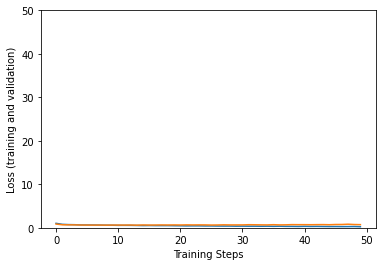

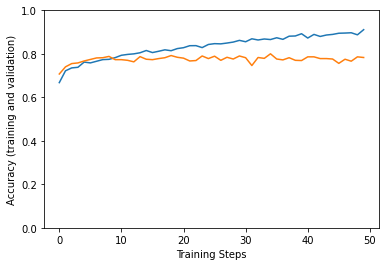

In [84]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [85]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [86]:
dataset_labels = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Akiec' 'Bcc' 'Bkl' 'Df' 'Mel' 'Nv' 'Vasc']


In [87]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 7)


In [88]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Nv' 'Nv' 'Nv' 'Nv' 'Bkl' 'Nv' 'Nv' 'Bkl' 'Nv' 'Nv' 'Nv' 'Nv' 'Nv' 'Mel'
 'Akiec' 'Nv' 'Nv' 'Nv' 'Nv' 'Bkl' 'Nv' 'Nv' 'Nv' 'Bkl' 'Bcc' 'Nv' 'Nv'
 'Nv' 'Mel' 'Nv' 'Mel' 'Mel']


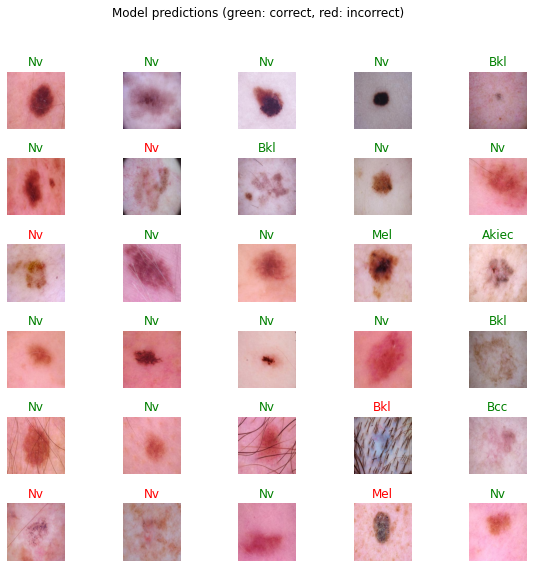

In [89]:

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")